final text_encoder_type: bert-base-uncased


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


[tensor([0.1098, 0.9003, 0.0055, 0.0100], device='cuda:0'), tensor([0.6023, 0.5625, 0.0073, 0.0083], device='cuda:0')]
tensor([0.1098, 0.9003, 0.0055, 0.0100], device='cuda:0')
1080 1920


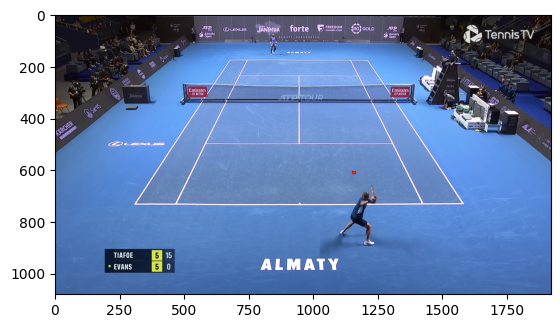

In [22]:
import os

import cv2
import numpy as np
import torch
from groundingdino.util.inference import batch_predict, load_image_quarters, load_model
from tqdm import tqdm

from tennis_tracker.download_data.extract_keypoints import (
    read_json_file,
    write_to_json_file,
)
from tennis_tracker.player_location.homography import transform_points


def output_point(m: np.array, points: np.array) -> list:
    """points should be in shape (-1, 1, 2)"""
    outputs = cv2.perspectiveTransform(points, m)
    # output will be -1, 1, 2
    return outputs.reshape(-1, 2)

from matplotlib import pyplot as plt


if __name__ == "__main__":

    model = load_model(
        "/home/da2986/tennis_tracker/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
        "/home/da2986/tennis_tracker/GroundingDINO/groundingdino_swint_ogc.pth",
    )
    # model = torch.compile(model)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    TEXT_PROMPT = "tennis ball"
    BOX_TRESHOLD = 0.35
    TEXT_TRESHOLD = 0.25
    JSON_PATH = (
        "/home/da2986/tennis_tracker/tennis_tracker/pseudo_label/clean_labels.json"
    )

    data = read_json_file(JSON_PATH)
    img_paths = [img_path for img_path in data.keys()]

    batch_size = 1
    OUTPUT_JSON_PATH = "/home/da2986/tennis_tracker/tennis_tracker/ball_tracking/labels.json"
    
    if os.path.exists(OUTPUT_JSON_PATH):
        os.remove(OUTPUT_JSON_PATH)
        
    img_paths = img_paths[0:1]

    for i in tqdm(range(0, len(img_paths), batch_size)):
        batch_images = img_paths[i : i + batch_size]
        loaded_images = []
        for image in batch_images:
            image_source, image = load_image_quarters(image)
            loaded_images.extend(image)
        input_images = torch.stack(loaded_images)
        boxes, logits, boxes_to_im = batch_predict(
            model=model,
            preprocessed_images=input_images,
            caption=TEXT_PROMPT,
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD,
            device=device,
        )
        lines = []
        final_boxes = []
        for im_num in range(len(batch_images) * 4):
            # get all the boxes that correspond to this image
            im_boxes = boxes[torch.Tensor(boxes_to_im) == im_num]
            all_boxes = []
            if len(im_boxes) > 0:
                for box in im_boxes:
                    box[0] *= 0.5
                    box[1] *= 0.5
                    box[2] *= 0.5
                    box[3] *= 0.5
                    if im_num % 4 == 0:
                        pass
                    elif im_num % 4 == 1:
                        box[0] += 0.5
                    elif im_num % 4 == 2:
                        box[1] += 0.5
                    elif im_num % 4 == 3:
                        box[0] += 0.5
                        box[1] += 0.5
                    all_boxes.append(f"0 {box[0]} {box[1]} {box[2]} {box[3]}")
                    final_boxes.append(box)

def plot_box(box: list, image: np.array):
    cx, cy, w, h = box
    image_height, image_width, _ = image.shape
    print(image_height, image_width)
    x1 = int((cx - w/2) * image_width)
    x2 = int((cx + w/2) * image_width)
    y1 = int((cy - h/2) * image_height)
    y2 = int((cy + h/2) * image_height) 
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='red', fill=False))
    plt.show()

print(final_boxes)
print(final_boxes[0])
plot_box(final_boxes[1], image_source)

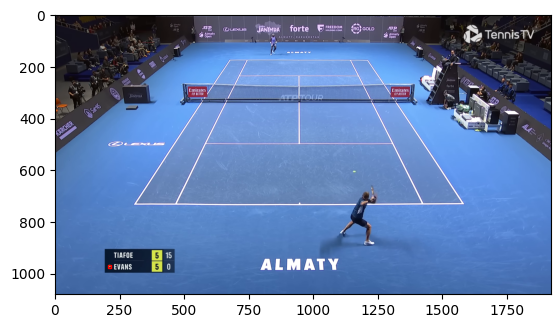

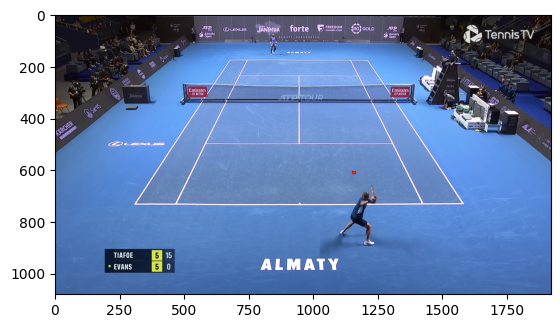

In [27]:
def plot_box(box: list, image: np.array):
    cx, cy, w, h = box
    image_height, image_width, _ = image.shape
    x1 = int((cx - w/2) * image_width)
    x2 = int((cx + w/2) * image_width)
    y1 = int((cy - h/2) * image_height)
    y2 = int((cy + h/2) * image_height) 
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='red', fill=False))
    plt.show()
    
data = read_json_file("/home/da2986/tennis_tracker/tennis_tracker/ball_tracking/labels.json")
new_ = "/home/da2986/tennis_tracker/tennis_tracker/download_data/frames/Tiafoe Takes On Evans; Khachanov & Mannarino Also In Action ｜ Almaty 2024 Highlights Day 4 [Q1iTjk444RU]/1000.png"
data[new_]
ball_tracking_boxes = data[new_]['ball_tracking_boxes']
image_source = cv2.imread(new_)
image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)
for box in ball_tracking_boxes:
    box = [float(x) for x in box.split(" ")[1:]]
    plot_box(box, image_source)